In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [35]:
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.models import get_model, get_weight

weights = get_weight("ResNet50_Weights.IMAGENET1K_V2")
model = get_model("resnet50", weights=weights)
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model.eval()

transform = weights.transforms()

dataset_path = 'train'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
data_loader = DataLoader(dataset, batch_size=32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


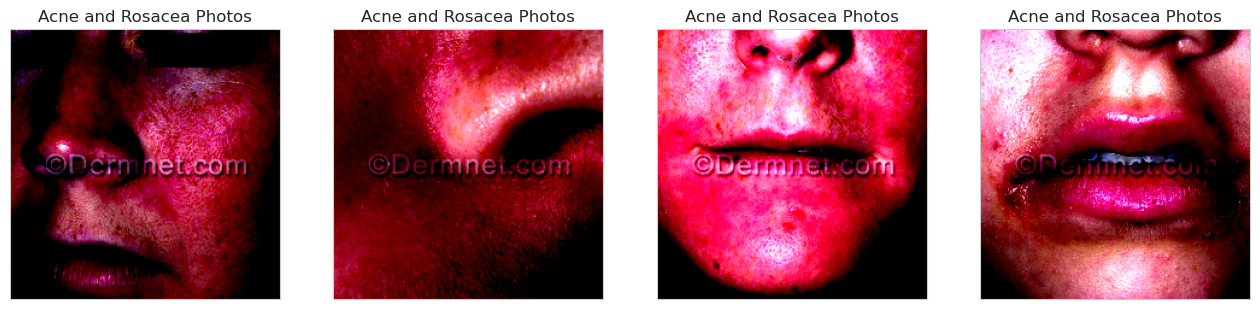

In [36]:
images, labels = next(iter(data_loader))

label_map = {v: k for k, v in dataset.class_to_idx.items()}

fig = plt.figure(figsize=(16, 8))
for i in range(4):
    ax = fig.add_subplot(2, 4, i+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[i+4], (1, 2, 0)))
    ax.set_title(label_map[labels[i+4].item()])
plt.show()

## Feature extraction

In [37]:
from tqdm import tqdm

def extract_features(model, dataloader):
    features = []
    with torch.no_grad():
        for inputs, _ in tqdm(dataloader, total=len(dataloader)):
            outputs = model(inputs)
            outputs = outputs.view(outputs.size(0), -1)
            features.append(outputs)        
    features = torch.cat(features)
    return features

features = extract_features(model, data_loader)
features = features.numpy()
np.save('resnet_features.npy', features)
print(f"Features shape: {features.shape}")

100%|██████████| 487/487 [17:15<00:00,  2.13s/it]

Features shape: (15557, 2048)


## Dimensionality reduction

In [39]:
features = np.load('resnet_features.npy')

In [40]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features = scaler.fit_transform(features)

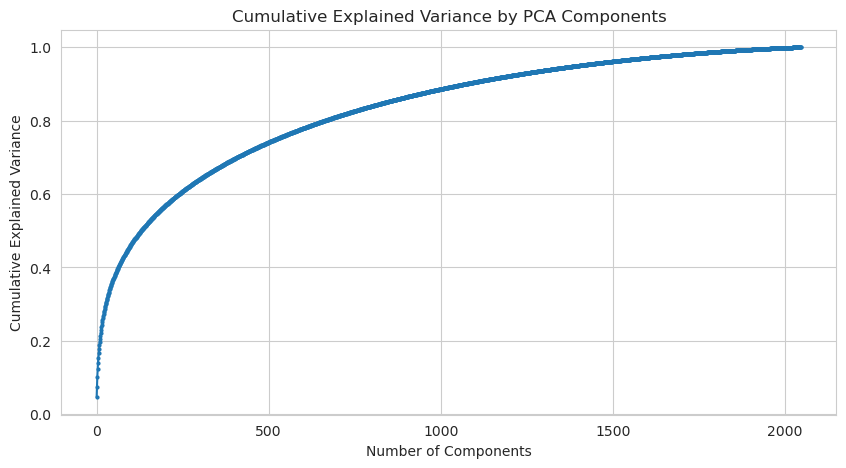

In [41]:
from sklearn.decomposition import PCA

pca_full = PCA()
pca_full.fit(features)

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(10, 5))
plt.plot(cumulative_variance, marker='o', markersize=2)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)
plt.show()

In [45]:
variance_threshold = 0.80
components_for_threshold = np.where(cumulative_variance >= variance_threshold)[0][0] + 1

print(f"Number of components needed to explain {variance_threshold*100}% of variance: {components_for_threshold}")

pca_optimal = PCA(n_components=components_for_threshold)
reduced_features = pca_optimal.fit_transform(features)

np.save('reduced_features.npy', reduced_features)
print(f"Reduced features shape: {reduced_features.shape}")

Number of components needed to explain 80.0% of variance: 664
Reduced features shape: (15557, 664)


## Clustering

In [ ]:
# kmeans, dbscan, hdbscan, optics, birch, agglomerative???

In [3]:
reduced_features = np.load('reduced_features.npy')

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
reduced_features = scaler.fit_transform(reduced_features)

In [12]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def calculate_metrics(features, cluster_labels):
    silhouette = silhouette_score(features, cluster_labels) 
    dbi = davies_bouldin_score(features, cluster_labels)
    ch = calinski_harabasz_score(features, cluster_labels)
    
    return silhouette, dbi, ch

def plot_metrics(param_range, silhouette_scores, dbi_scores, ch_scores, param_name):
    plt.figure(figsize=(14, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(param_range, silhouette_scores, marker='o')
    plt.xlabel(param_name)
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Score by {param_name}')
    plt.grid(True)
    
    plt.subplot(2, 2, 2)
    plt.plot(param_range, dbi_scores, marker='o')
    plt.xlabel(param_name)
    plt.ylabel('Davies-Bouldin Index')
    plt.title(f'Davies-Bouldin Index by {param_name}')
    plt.grid(True)
    
    plt.subplot(2, 2, 3)
    plt.plot(param_range, ch_scores, marker='o')
    plt.xlabel(param_name)
    plt.ylabel('Calinski-Harabasz Index')
    plt.title(f'Calinski-Harabasz Index by {param_name}')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

### K-means

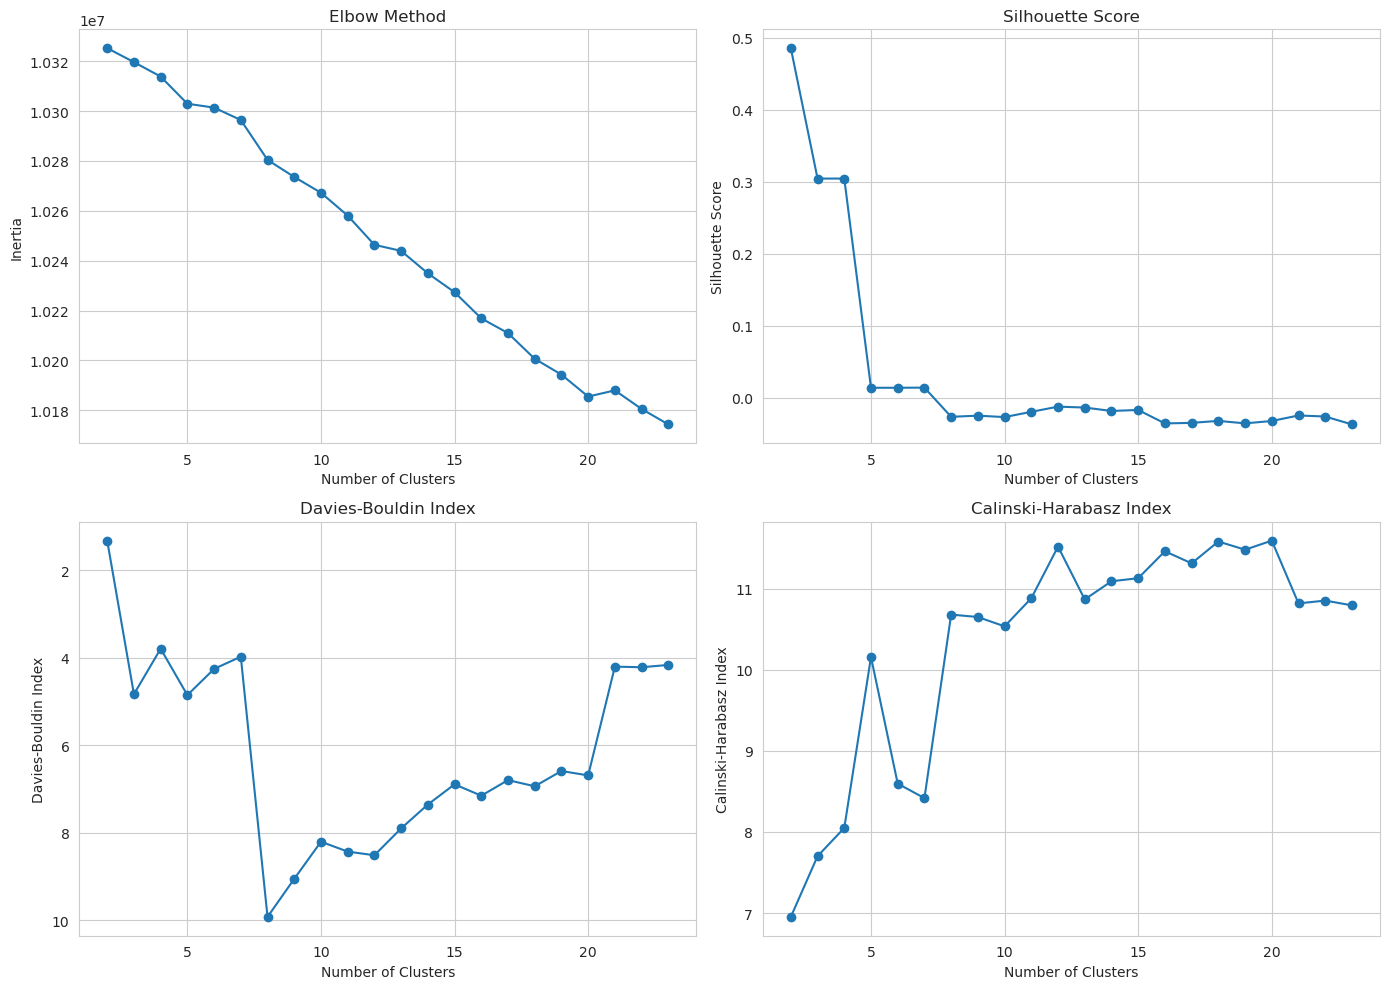

In [8]:
from sklearn.cluster import KMeans

K_range = range(2, 24)

inertias = []
silhouette_scores = []
dbi_scores = []
ch_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(reduced_features)
    
    inertias.append(kmeans.inertia_)
    silhouette, dbi, ch = calculate_metrics(reduced_features, cluster_labels)
    silhouette_scores.append(silhouette)
    dbi_scores.append(dbi)
    ch_scores.append(ch)

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(K_range, inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(K_range, dbi_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(K_range, ch_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index')
plt.grid(True)

plt.tight_layout()
plt.show()

In [9]:
cluster_sizes = np.bincount(cluster_labels)
cluster_sizes

array([    1,  1500,  1453,   159,     2,   169,     2,    25, 12094,
          87,     1,     2,     1,     1,     1,    40,     8,     1,
           1,     3,     1,     4,     1])

### HDBSCAN
The HDBSCAN algorithm can be seen as an extension of DBSCAN and OPTICS. Specifically, DBSCAN assumes that the clustering criterion (i.e. density requirement) is globally homogeneous. In other words, DBSCAN may struggle to successfully capture clusters with different densities. HDBSCAN alleviates this assumption and explores all possible density scales by building an alternative representation of the clustering problem - [Sklearn documentation](https://scikit-learn.org/stable/modules/clustering.html#references-8).


In [10]:
from sklearn.cluster import HDBSCAN

hdbscan = HDBSCAN(min_cluster_size=50)
cluster_labels = hdbscan.fit_predict(reduced_features)

cluster_sizes = pd.Series(cluster_labels).value_counts()
cluster_sizes

In [11]:
cluster_sizes

-1    15557
Name: count, dtype: int64